# Cleaning and EDA

## Data Cleaning

### Read the data

In [ ]:
import pandas as pd
import chardet

with open('Data/data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

encoding = 'Windows-1252'  

# Read the CSV file with the detected encoding
raw_df = pd.read_csv('Data/data.csv', encoding=encoding, header=0)  

# Set column name as 'sentiment' and 'comment'
raw_df.columns = ['sentiment', 'comment']

print(raw_df.head())

### Create a comment column with only nouns

In [ ]:
import spacy

# Combine all comments into a single string
text = " ".join(raw_df['comment'])

# Load the English language model
nlp = spacy.load('en_core_web_sm')

# Function to extract nouns from a comment
def extract_nouns(text):
    doc = nlp(text)
    nouns = [token.text for token in doc if token.pos_ == 'NOUN']
    return " ".join(nouns)

# Apply the function to each comment
raw_df['nouns'] = raw_df['comment'].apply(extract_nouns)

# Display the DataFrame with extracted nouns
print(raw_df.head())

# Save this new df to a new CSV file
raw_df.to_csv('Data/clean_data.csv', index=False)

## EDA

### Sentiment count distribution

utf-8


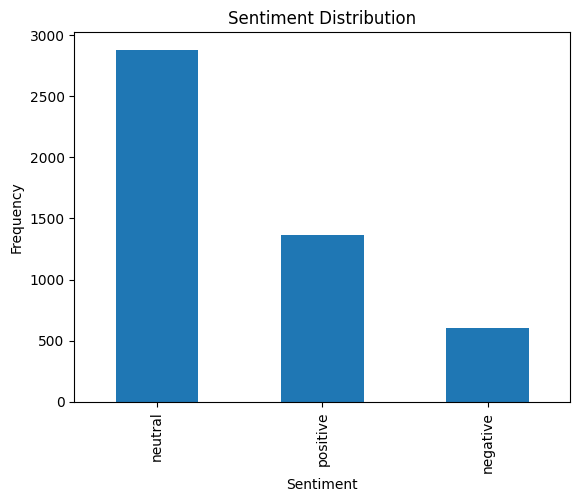

In [3]:
import pandas as pd
import chardet
import matplotlib.pyplot as plt

with open('Data/clean_data.csv', 'rb') as f:
    result = chardet.detect(f.read())
    print(result['encoding'])

encoding = 'Windows-1252'  

# Read the CSV file with the detected encoding
df = pd.read_csv('Data/clean_data.csv', encoding=encoding, header=0) 

# Plot the sentiment distribution
sentiment_count = df['sentiment'].value_counts()
sentiment_count.plot(kind = 'bar')
plt.title('Sentiment Distribution')
plt.xlabel('Sentiment')
plt.ylabel('Frequency')
plt.show()

### Wordcloud for all sentiment

In [ ]:
from wordcloud import WordCloud, STOPWORDS
import matplotlib.pyplot as plt

# Custom stopwords
custom_stopwords = set(STOPWORDS)
custom_stopwords.update(['will', 'mn', 'm']) 

# Create a word cloud object
wordcloud = WordCloud(
    width=800,                # Width of the canvas
    height=400,               # Height of the canvas
    background_color='white', # Background color of the word cloud
    max_words=50,            # Maximum number of words to display
    contour_color='steelblue',# Color of the contour
    contour_width=1,          # Width of the contour line
    colormap='viridis',       # Color map for the words
    stopwords=custom_stopwords            # Stopwords to exclude (default is None)
).generate(df['nouns'].str.cat(sep=' '))  # Concatenate all nouns into a single string

# Display the generated word cloud
plt.figure(figsize=(10, 5))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')  # Turn off axis lines and labels
plt.title('Word Cloud of Comments', fontsize=16)
plt.show()


### Wordclourd per sentiment

In [ ]:
from wordcloud import WordCloud

def plot_wordcloud(text, title):
    # Custom stopwords
    custom_stopwords = set(STOPWORDS)
    custom_stopwords.update(['will', 'mn', 'mln,' 'Company', 'Finnish', 'year']) 

    wordcloud = WordCloud(width=800, height=400, background_color='white', max_words=75, stopwords=custom_stopwords).generate(text)
    plt.figure(figsize=(10, 5))
    plt.imshow(wordcloud, interpolation='bilinear')
    plt.axis('off')
    plt.title(title, fontsize=16)
    plt.show()

# Fill NaN values in the 'nouns' column with an empty string
df['nouns'] = df['nouns'].fillna('')

positive_text = " ".join(df[df['sentiment'] == 'positive']['nouns'])
negative_text = " ".join(df[df['sentiment'] == 'negative']['nouns'])
neutral_text = " ".join(df[df['sentiment'] == 'neutral']['nouns'])

plot_wordcloud(positive_text, 'Positive Comments')
plot_wordcloud(negative_text, 'Negative Comments')
plot_wordcloud(neutral_text, 'Neutral Comments')


### Text length distribution per sentiment

In [ ]:
df['comment_length'] = df['comment'].apply(len)

df.hist(column='comment_length', by='sentiment', bins=20, figsize=(10, 6))
plt.suptitle('Distribution of Comment Lengths by Sentiment')
plt.show()

# Comment length mean by sentiment
mean_length = df.groupby('sentiment')['comment_length'].mean()
print(mean_length)

### Most common words per category

In [ ]:
from collections import Counter
import re

def get_top_n_words(corpus, n=10, stopwords=None):
    if stopwords is None:
        stopwords = set()
    words = re.findall(r'\w+', corpus.lower())
    filtered_words = [word for word in words if word not in stopwords]
    return Counter(filtered_words).most_common(n)

# Define custom stopwords
custom_stopwords = {'mn', 'mln', 'will','m', 's', 'eur', 'pct', 'company', 'said', 'finnish', 'year'}

# Get top words while excluding stopwords
positive_words = get_top_n_words(positive_text, 10, stopwords=custom_stopwords)
negative_words = get_top_n_words(negative_text, 10, stopwords=custom_stopwords)
neutral_words = get_top_n_words(neutral_text, 10, stopwords=custom_stopwords)

print('Top 10 words in positive comments:', positive_words)
print('Top 10 words in negative comments:', negative_words)
print('Top 10 words in neutral comments:', neutral_words)


In [ ]:
from sklearn.feature_extraction.text import CountVectorizer
import pandas as pd

# Sample DataFrame (assuming 'nouns' column is pre-processed and available)
# df = pd.DataFrame({...})

# Function to get top n-grams
def get_top_n_ngrams(corpus, n=10, ngram_range=(2, 2), stopwords=None):
    if stopwords is None:
        stopwords = []
    
    # Convert stopwords to a list if it's a set
    stopwords = list(stopwords)
    
    vec = CountVectorizer(ngram_range=ngram_range, stop_words=stopwords).fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    
    return words_freq[:n]

# Define custom stopwords
custom_stopwords = ['mn', 'mln', 'will', 'm', 's', 'eur', 'pct', 'company', 'said', 'finnish', 'year']

# Get top bigrams while excluding custom stopwords
positive_bigrams = get_top_n_ngrams(df[df['sentiment'] == 'positive']['nouns'], 10, (2, 2), stopwords=custom_stopwords)
negative_bigrams = get_top_n_ngrams(df[df['sentiment'] == 'negative']['nouns'], 10, (2, 2), stopwords=custom_stopwords)
neutral_bigrams = get_top_n_ngrams(df[df['sentiment'] == 'neutral']['nouns'], 10, (2, 2), stopwords=custom_stopwords)

# Print the results
print('Top 10 bigrams in positive comments:', positive_bigrams)
print('Top 10 bigrams in negative comments:', negative_bigrams)
print('Top 10 bigrams in neutral comments:', neutral_bigrams)


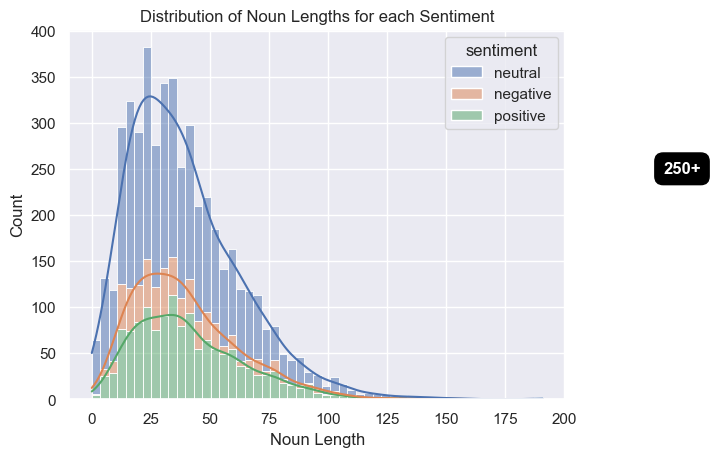

In [5]:
import seaborn as sns
import matplotlib.pyplot as plt

# Assuming df is your DataFrame and 'nouns' is the column with extracted nouns

# Fill NaN values in the 'nouns' column with an empty string
df['nouns'] = df['nouns'].fillna('')

# Calculate the length of the noun phrases
df['nouns_length'] = df['nouns'].apply(len)

# Set the style of the plot
sns.set(style="darkgrid")

# Filter the noun lengths less than or equal to 250
filtered_df = df[df['nouns_length'] <= 250]

# Plot the distribution of noun lengths for each sentiment
sns.histplot(data=filtered_df, x="nouns_length", hue="sentiment", multiple="stack", kde=True)

# Set the title and labels
plt.title("Distribution of Noun Lengths for each Sentiment")
plt.xlabel("Noun Length")
plt.ylabel("Count")

# Add a label for noun lengths greater than 250
plt.text(250, 250, '250+', ha='center', va='center', color='white', fontweight='bold', fontsize=12,
         bbox=dict(facecolor='black', edgecolor='black', boxstyle='round,pad=0.5'))

# Show the plot
plt.show()
